# Velocity Distributions - Generate scale-independent fits

2 sigmas and lambda - $10^{13.5-14}$ $M_\odot$

In [1]:
import h5py
import numpy as np
from matplotlib.pyplot import figure,show
# from swiftsimio import load
import pandas as pd
from scipy.stats import norm
# import matplotlib.mlab as mlab
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
# from lmfit.models import LorentzianModel, VoigtModel, GaussianModel,LognormalModel
from scipy.integrate import fixed_quad, quad, dblquad


In [2]:
path_hydro= "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    TotalMass= handle["ExclusiveSphere/100kpc/TotalMass"][:]
    StellarMass = handle["ExclusiveSphere/100kpc/StellarMass"][:]
    COMstellarvelocity=handle["ExclusiveSphere/100kpc/StellarCentreOfMassVelocity"][:]
    COMvelocity=handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    Trackid=handle["InputHalos/HBTplus/TrackId"][:]
    HOSTFOFID=handle["InputHalos/HBTplus/HostFOFId"][:]
    HaloCatalogueIndex=handle["InputHalos/HaloCatalogueIndex"][:]
    HOSTHALOINDEX=handle["SOAP/HostHaloIndex"][:]
    FOFMass=handle["InputHalos/FOF/Masses"][:]
    NoofBoundParticles=handle["InputHalos/NumberOfBoundParticles"][:]
    NoofDMParticles=handle["ExclusiveSphere/100kpc/NumberOfDarkMatterParticles"][:]
    COM=handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    IsCentral = handle["InputHalos/IsCentral"][:].astype(bool)
    SOMass = handle['SO/200_mean/TotalMass'][:]


In [3]:
df = pd.DataFrame({
    'HOST_FOF' :  HOSTFOFID,
    'HostHaloIndex':HOSTHALOINDEX, # -1 for central halos
    'Catalogue Index': HaloCatalogueIndex,
    'Track ID' : Trackid,
    'mass':TotalMass,
    'FOFMass':FOFMass,
    'COM v- x':COMvelocity[:,0],
    'COM v- y':COMvelocity[:,1],
    'COM v- z':COMvelocity[:,2],
    'COM - x':COM[:,0],
    'COM - y':COM[:,1],
    'COM - z':COM[:,2],
    'Bound Particles No':NoofBoundParticles,
    'DM Particles No': NoofDMParticles,
    'IsCentral' : IsCentral,
    'SOMass' : SOMass
})
df['INDEX_HOST_HALOS']=np.asarray(df.index)

DF_BOUND_NO_FILTERED= df[df['Bound Particles No']>=100]
display(df)
# display(DF_BOUND_NO_FILTERED)

,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS
0,1039187,-1,646,32298,168.000000,1164.000000,-202.030396,140.269531,-579.830444,23.734835,17.830045,24.049015,1356,274,True,1146.000000,0
1,1039314,-1,1512,96387,208.250000,1120.000000,-299.430420,118.769531,-304.930420,19.606055,21.428705,15.315335,2452,338,True,1180.000000,1
2,1041401,-1,1516,96393,199.000000,635.000000,-620.230408,279.169556,-632.630432,1.985425,14.544495,15.552605,1269,323,True,663.000000,2
3,1040958,-1,1768,240562,221.500000,732.000000,-303.430420,255.969604,-132.930420,20.112205,8.779495,3.317025,1522,365,True,795.000000,3
4,1038214,-1,1851,240661,376.500000,1846.000000,-343.330444,307.469604,-231.930420,15.549465,10.733535,7.873675,4111,604,True,2002.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329648,1192733,-1,32187281,32187281,10.046875,17.031250,223.907593,678.007568,-307.092407,972.009585,977.686395,972.474395,31,17,True,12.296875,15329648
15329649,1195874,-1,32187284,32187284,7.671875,15.546875,237.707642,622.907593,-439.292389,987.985825,980.917505,997.726705,30,13,True,10.609375,15329649
15329650,1199190,-1,32187288,32187288,7.109375,15.437500,288.507568,838.807617,-438.092377,973.485265,981.180935,993.807645,33,12,True,9.812500,15329650
15329651,1202840,-1,32187293,32187293,5.656250,16.718750,20.507629,778.907593,-166.492371,979.062535,990.945435,969.533915,29,10,True,6.914062,15329651


In [4]:
df[df['HostHaloIndex'] != -1]

def _make_mass_mask(mass: np.ndarray, m_min: np.float32, m_max: np.float32) -> np.ndarray:
    if m_min in [0,-1,np.nan, None]:
        return (mass <= 10**m_max)
    elif m_max in [0,-1,np.nan, None]:
        return (10**m_min <= mass)
    return (10**m_min <= mass) & (mass <= 10**m_max) 

test1 = df[_make_mass_mask(df['FOFMass'].values,2,2.5)]
hostindex = test1.index
filtered = df[df['HostHaloIndex'].isin(hostindex)].sort_values(by='HostHaloIndex')
filtered.groupby('HostHaloIndex')['HostHaloIndex'].transform('count')

143         2
58          2
340         2
156         2
336         1
           ..
15329477    2
15329461    2
15329512    1
15329556    1
15329514    1
Name: HostHaloIndex, Length: 659041, dtype: int64

In [5]:
df[~df['IsCentral'].values]['FOFMass']

8           0.0
17          0.0
21          0.0
22          0.0
26          0.0
           ... 
15329626    0.0
15329631    0.0
15329633    0.0
15329635    0.0
15329647    0.0
Name: FOFMass, Length: 3960840, dtype: float32

In [6]:
test1[~test1['IsCentral'].values]

,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS


In [7]:
def final_velocity(df,lower_mass,upper_mass):
    #filtering FOF groups based on mass
    if upper_mass==-1:
        M_bin=df[df['SOMass']>=lower_mass] 
    elif lower_mass==-1:
        M_bin=df[(df['FOFMass']<upper_mass)]
    else:
        M_bin=df[(df['SOMass']>=lower_mass)& (df['SOMass']<=upper_mass)] 
    HOSTINDICES=np.asarray(M_bin.index) #indices of hosts
    display(M_bin)
    print(len(HOSTINDICES)) #check number of host halos
    filtereddf=df.loc[df['HostHaloIndex'].isin(HOSTINDICES)].sort_values(by='HostHaloIndex') #filters all subhalos within each FOF group in M_bin
    print(min(filtereddf['HostHaloIndex']))
    print(len(np.unique(np.array(filtereddf['HostHaloIndex']))))
    # finding number of subhalos in each FOF group
    filtereddf['freq'] = filtereddf.groupby('HostHaloIndex')['HostHaloIndex'].transform('count')
    display(filtereddf)
    print()
    df2=filtereddf.groupby('HostHaloIndex')['freq'].mean()
    display(df2)
    FINALHOSTINDICES=df2.index
    offsets=df2.values.astype(int)

    M_bin=M_bin[M_bin['INDEX_HOST_HALOS'].isin(FINALHOSTINDICES)] #making sure that the groups corresponding to the subhalos are used 
    HOSTHALO_INDICES=np.asarray(M_bin.index)

    #center of mass vel of each group
    HOSTHALOVEL_X=np.asarray(M_bin['COM v- x'])
    HOSTHALOVEL_Y=np.asarray(M_bin['COM v- y'])
    HOSTHALOVEL_Z=np.asarray(M_bin['COM v- z'])
    #positions
    HOSTHALO_X=np.asarray(M_bin['COM - x'])
    HOSTHALO_Y=np.asarray(M_bin['COM - y'])
    HOSTHALO_Z=np.asarray(M_bin['COM - z'])
    #center of mass vel of each subhalo
    SUBHALO_X=np.asarray(filtereddf['COM v- x'])
    SUBHALO_Y=np.asarray(filtereddf['COM v- y'])
    SUBHALO_Z=np.asarray(filtereddf['COM v- z'])
    
    #subhalo positions
    SUBHALO_x=np.asarray(filtereddf['COM - x'])
    SUBHALO_y=np.asarray(filtereddf['COM - y'])
    SUBHALO_z=np.asarray(filtereddf['COM - z'])

    #relative quantities
    subhalo_relvel_x=np.zeros(len(SUBHALO_X))
    subhalo_relvel_y=np.zeros(len(SUBHALO_X))
    subhalo_relvel_z=np.zeros(len(SUBHALO_X))
    
    subhalo_rel_x=np.zeros(len(SUBHALO_X))
    subhalo_rel_y=np.zeros(len(SUBHALO_X))
    subhalo_rel_z=np.zeros(len(SUBHALO_X))
    print(len(HOSTHALO_INDICES), len(HOSTHALOVEL_X)) #check 
    
    count_lower=0
    count_upper=0
    for i in range(len(HOSTHALO_INDICES)):
        CENTRAL_VELX=HOSTHALOVEL_X[i]
        CENTRAL_VELY=HOSTHALOVEL_Y[i]
        CENTRAL_VELZ=HOSTHALOVEL_Z[i]
        CENTRAL_X=HOSTHALO_X[i]
        CENTRAL_Y=HOSTHALO_Y[i]
        CENTRAL_Z=HOSTHALO_Z[i]

        count_upper+=offsets[i]
        
        # print(count_lower,count_upper) - check if needed
        
        subhalo_relvel_x[count_lower:count_upper]=SUBHALO_X[count_lower:count_upper]-CENTRAL_VELX
        subhalo_relvel_y[count_lower:count_upper]=SUBHALO_Y[count_lower:count_upper]-CENTRAL_VELY
        subhalo_relvel_z[count_lower:count_upper]=SUBHALO_Z[count_lower:count_upper]-CENTRAL_VELZ

        subhalo_rel_x[count_lower:count_upper]=CENTRAL_X- SUBHALO_x[count_lower:count_upper]
        subhalo_rel_y[count_lower:count_upper]=CENTRAL_Y-SUBHALO_y[count_lower:count_upper]
        subhalo_rel_z[count_lower:count_upper]=CENTRAL_Z-SUBHALO_z[count_lower:count_upper]

        count_lower+=offsets[i]
    
    # print(count_lower,count_upper) - check if needed
    
    final_velx=subhalo_relvel_x
    final_vely=subhalo_relvel_y
    final_velz=subhalo_relvel_z
    final_relx=subhalo_rel_x
    final_rely=subhalo_rel_y
    final_relz=subhalo_rel_z
    total_vel_xyz=np.concatenate((final_velx,final_vely,final_velz), axis=None) 

    return final_velx,final_vely,final_velz,total_vel_xyz,final_relx,final_rely,final_relz


    


In [8]:
M15_final_velx,M15_final_vely,M15_final_velz,M15_total_Vel,M15_final_x,M15_final_y,M15_final_z=final_velocity(DF_BOUND_NO_FILTERED,10**3.5,10**4)


,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS
1739,779899,-1,240602,242420,735.00,4952.0,-175.738403,-525.238403,-361.338379,29.764928,1.715218,182.265118,13303,1148,True,5512.0,1739
1765,780049,-1,257170,2800896,436.00,4408.0,-480.638428,-667.838440,751.461670,31.172308,6.370838,168.673808,8671,688,True,4920.0,1765
2223,779687,-1,241451,243418,471.50,8560.0,-275.110840,-54.310913,-86.810913,10.005008,12.772778,213.699988,15313,741,True,8224.0,2223
2224,779944,-1,241455,243423,394.00,5056.0,-465.210876,-370.110840,232.889160,18.141298,15.348118,208.998078,5139,626,True,4992.0,2224
2238,779916,-1,246044,1011694,427.00,5208.0,-442.910889,224.789185,-172.310913,15.066878,12.446828,212.553458,11304,659,True,5440.0,2238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15327832,1037227,-1,31926997,1743252,215.75,4152.0,557.351318,77.951416,325.051270,980.573156,992.437686,931.589796,3357,348,True,4648.0,15327832
15328664,1037284,-1,31920281,240257,355.50,4060.0,42.972778,757.772827,-263.527222,991.889780,983.736550,958.082170,8248,565,True,4060.0,15328664
15328684,1036883,-1,31937220,2792074,612.00,7664.0,195.372803,585.572754,-192.227173,989.275980,985.835310,957.715140,17602,966,True,8752.0,15328684
15329201,1037294,-1,31919934,239868,394.00,4136.0,344.007568,392.607666,-93.092407,991.309185,980.018905,992.216575,4661,626,True,4280.0,15329201


44210
1765
42887


,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS,freq
1889,780049,1765,324296,14386790,31.31250,0.0,-75.238403,-508.138428,696.361572,30.296048,6.764768,168.309408,121,48,False,0.0,1889,3
1915,780049,1765,333915,16107105,37.50000,0.0,-83.738403,-935.938416,777.761475,30.338278,6.959038,167.979908,136,59,False,0.0,1915,3
469771,780049,1765,243693,523798,210.50000,0.0,-549.605530,-559.005493,358.394531,31.343538,6.409628,168.332248,1055,342,False,0.0,469771,3
2218,779687,2223,240749,242594,109.37500,0.0,-70.010864,231.989136,-68.610840,8.861618,13.332268,213.529598,457,173,False,0.0,2218,13
2222,779687,2223,241157,243078,200.25000,0.0,-275.510864,-196.710815,-297.210815,9.265258,13.988328,213.158908,832,331,False,0.0,2222,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15328672,1036883,15328684,31925820,1004905,190.25000,0.0,870.972778,-91.627197,-32.927246,989.021650,986.155400,957.718640,1201,305,False,0.0,15328672,6
15329316,1037294,15329201,32011526,2731286,314.50000,0.0,155.807617,813.307617,-374.592407,991.731945,979.506905,992.248155,3543,493,False,0.0,15329316,3
15329356,1037294,15329201,32040659,18672798,33.06250,0.0,192.507568,195.907593,-35.492371,991.109965,979.984855,993.102965,115,52,False,0.0,15329356,3
15329266,1037294,15329201,31975050,7768177,62.00000,0.0,206.407593,728.707642,-774.492371,991.753965,979.486505,992.812255,218,97,False,0.0,15329266,3


HostHaloIndex
1765         3.0
2223        13.0
2224         6.0
2238         7.0
3249         2.0
            ... 
15327832     9.0
15328664     4.0
15328684     6.0
15329201     3.0
15329205     1.0
Name: freq, Length: 42887, dtype: float64

42887 42887


In [9]:
M15_total_Vel.shape

(598389,)

### Maximum likelihood estimation

In [10]:
def gaussian(x,mu,sigma):
    return  np.exp(-0.5 * ((x -mu) / sigma) ** 2)

def gaussian_integral(mu,sigma,x_i,x_f):
    integral,_=quad(lambda x: gaussian(x,mu,sigma), x_i, x_f)
    return integral
    

def gaussian_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    mu,sigma=params
    hist_area=np.sum(bin_heights) 
    fit_integral =(sigma * np.sqrt(2 * np.pi))
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A* gaussian_integral(mu,sigma,bin_edges[i-1],bin_edges[i])
        #penalize negative values and zero
        if f_b<=0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L
    

In [11]:
def laplace(x, mu, b): 
    return (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)

def laplace_integral(mu,b,x_i,x_f):
    integral,_=quad(lambda x: laplace(x, mu, b), x_i, x_f)
    return integral

def laplace_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    mu,b=params
    hist_area=np.sum(bin_heights) 
    fit_integral =laplace_integral(mu,b,-np.inf,np.inf)
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A* laplace_integral(mu,b,bin_edges[i-1],bin_edges[i])
        if f_b<0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L

In [12]:
def lorentzian(x,mu,gamma):
    return 1/ ((1+((x-mu)/gamma)**2))


def lorentzian_integral(mu,gamma,x_i,x_f):
    integral,_=quad(lambda x: lorentzian(x,mu,gamma), x_i, x_f)
    return integral


def lorentzian_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    mu,gamma=params
    hist_area=np.sum(bin_heights)
    fit_integral=np.pi*gamma
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A*lorentzian_integral(mu,gamma,bin_edges[i-1],bin_edges[i])
        if f_b<0:
            return 10**11
        n_b=bin_heights[i-1] 
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L



### Sum of two gaussians (best model in the thesis):-

In [ ]:
def mod_gaussian(x,sigma,sigma1,lambda_):
    return ((1-lambda_)* (np.exp(-(x)**2 / (2 * sigma**2)) /sigma ) +lambda_*np.exp(-((x)**2/(2*sigma1**2)))/sigma1)/ (np.sqrt(2*np.pi))

def mod_gaussian_integral(sigma,lambda_,lambda2,x_i,x_f):
    integral,_=quad(lambda x: mod_gaussian(x,sigma,lambda_,lambda2), x_i, x_f)
    return integral
    

def mod_gaussian_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    sigma,lambda_,lambda2=params
    hist_area=np.sum(bin_heights) 
    fit_integral =(sigma * np.sqrt(2 * np.pi)) *(3*lambda_ + 1 + 105*lambda2)
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A* mod_gaussian_integral(sigma,lambda_,lambda2,bin_edges[i-1],bin_edges[i])
        #penalize negative values and zero
        if f_b<=0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L
    

In [14]:
def plot_distribution_gaussian_mod(f,integral_f,params,data,bins,distname):
    
    bin_heights, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width= bin_edges[1] - bin_edges[0] 
    bin_widths = np.diff(bin_edges)  # The width of each bin
    number_density = bin_heights / bin_widths  # Normalize by bin width
    # Plot the histogram
    fig=figure(figsize=(7,7))
    frame=fig.add_subplot(1,1,1)
    frame.set_xlabel('Velocity difference v', fontsize=13)
    frame.set_ylabel('Number of galaxies per v', fontsize=13)
    frame.bar(bin_centers, number_density, width=bin_width, align='center')
    DAT=np.linspace(np.min(data),np.max(data),1000)
    hist_area=np.sum(bin_heights)
    fit_integral = integral_f(*params,-np.inf,np.inf) 
    A=hist_area/ fit_integral
    frame.plot(DAT,A*f(DAT,*params),'-', label=distname,color='red')
    # frame.set_yscale("log")
    frame.legend()

## trial stuff

In [15]:
M15_final_velx,M15_final_vely,M15_final_velz,M15_total_Vel,M15_final_x,M15_final_y,M15_final_z=final_velocity(DF_BOUND_NO_FILTERED,10**3.5,10**4)

,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS
1739,779899,-1,240602,242420,735.00,4952.0,-175.738403,-525.238403,-361.338379,29.764928,1.715218,182.265118,13303,1148,True,5512.0,1739
1765,780049,-1,257170,2800896,436.00,4408.0,-480.638428,-667.838440,751.461670,31.172308,6.370838,168.673808,8671,688,True,4920.0,1765
2223,779687,-1,241451,243418,471.50,8560.0,-275.110840,-54.310913,-86.810913,10.005008,12.772778,213.699988,15313,741,True,8224.0,2223
2224,779944,-1,241455,243423,394.00,5056.0,-465.210876,-370.110840,232.889160,18.141298,15.348118,208.998078,5139,626,True,4992.0,2224
2238,779916,-1,246044,1011694,427.00,5208.0,-442.910889,224.789185,-172.310913,15.066878,12.446828,212.553458,11304,659,True,5440.0,2238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15327832,1037227,-1,31926997,1743252,215.75,4152.0,557.351318,77.951416,325.051270,980.573156,992.437686,931.589796,3357,348,True,4648.0,15327832
15328664,1037284,-1,31920281,240257,355.50,4060.0,42.972778,757.772827,-263.527222,991.889780,983.736550,958.082170,8248,565,True,4060.0,15328664
15328684,1036883,-1,31937220,2792074,612.00,7664.0,195.372803,585.572754,-192.227173,989.275980,985.835310,957.715140,17602,966,True,8752.0,15328684
15329201,1037294,-1,31919934,239868,394.00,4136.0,344.007568,392.607666,-93.092407,991.309185,980.018905,992.216575,4661,626,True,4280.0,15329201


44210
1765
42887


,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,IsCentral,SOMass,INDEX_HOST_HALOS,freq
1889,780049,1765,324296,14386790,31.31250,0.0,-75.238403,-508.138428,696.361572,30.296048,6.764768,168.309408,121,48,False,0.0,1889,3
1915,780049,1765,333915,16107105,37.50000,0.0,-83.738403,-935.938416,777.761475,30.338278,6.959038,167.979908,136,59,False,0.0,1915,3
469771,780049,1765,243693,523798,210.50000,0.0,-549.605530,-559.005493,358.394531,31.343538,6.409628,168.332248,1055,342,False,0.0,469771,3
2218,779687,2223,240749,242594,109.37500,0.0,-70.010864,231.989136,-68.610840,8.861618,13.332268,213.529598,457,173,False,0.0,2218,13
2222,779687,2223,241157,243078,200.25000,0.0,-275.510864,-196.710815,-297.210815,9.265258,13.988328,213.158908,832,331,False,0.0,2222,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15328672,1036883,15328684,31925820,1004905,190.25000,0.0,870.972778,-91.627197,-32.927246,989.021650,986.155400,957.718640,1201,305,False,0.0,15328672,6
15329316,1037294,15329201,32011526,2731286,314.50000,0.0,155.807617,813.307617,-374.592407,991.731945,979.506905,992.248155,3543,493,False,0.0,15329316,3
15329356,1037294,15329201,32040659,18672798,33.06250,0.0,192.507568,195.907593,-35.492371,991.109965,979.984855,993.102965,115,52,False,0.0,15329356,3
15329266,1037294,15329201,31975050,7768177,62.00000,0.0,206.407593,728.707642,-774.492371,991.753965,979.486505,992.812255,218,97,False,0.0,15329266,3


HostHaloIndex
1765         3.0
2223        13.0
2224         6.0
2238         7.0
3249         2.0
            ... 
15327832     9.0
15328664     4.0
15328684     6.0
15329201     3.0
15329205     1.0
Name: freq, Length: 42887, dtype: float64

42887 42887


In [16]:
df_scale=pd.DataFrame({
    'Relative pos - x':M15_final_x,
    'Relative pos - y':M15_final_y,
    'Relative pos - z':M15_final_z,
    'Relative radial distance':np.sqrt(M15_final_x**2+M15_final_y**2+M15_final_z**2),
    'Relative velocity - x':M15_final_velx,
    'Relative velocity - y':M15_final_vely,
    'Relative velocity - z':M15_final_velz,
})

In [17]:
df2=df_scale.sort_values(by=['Relative radial distance'])

len(df2['Relative velocity - z']) + len(df2['Relative velocity - x']) + len(df2['Relative velocity - y'])
print(np.array(df2['Relative radial distance']))

[6.71937497e-04 8.75956620e-04 1.08926581e-03 ... 9.99938871e+02
 9.99956601e+02 9.99961014e+02]


## Trial - binned 


In [18]:
r_values = df2['Relative radial distance']  
x_values =df2['Relative velocity - x']
y_values=df2['Relative velocity - y']
z_values= df2['Relative velocity - z']
r_bins=[(0,0.16),(0.16,0.225),(0.23,0.29),(0.29,0.325),(0.325,0.3625),(0.3625,0.4),(0.4,0.45),(0.45,0.5),(0.5,0.55),(0.55,0.6),(0.6,0.65),(0.65,0.7),(0.7,0.8),(0.8,1.0),(1.0,1.2),(1.2,5)] # for now
unbinned_velocity_values_in_each_rbin=[]
def bin_x_values(r_values, x_values, y_values,z_values, r_bins):
    binned_data = []
    c=0
    for r_min, r_max in r_bins:
        mask_r = (r_values >= r_min) & (r_values < r_max)
        x_vals = x_values[mask_r] 
        y_vals= y_values[mask_r]
        z_vals= z_values[mask_r]
        unbinned_velocity_values_in_each_rbin.append(np.concatenate((x_vals,y_vals,z_vals), axis=None))
        counts, bins = np.histogram(np.concatenate((x_vals,y_vals,z_vals), axis=None) , bins=80) 
        x_bins_list = [(float(bins[i]), float(bins[i+1]), int(counts[i])) for i in range(len(counts))]
        binned_data.append((float(r_min), float(r_max), x_bins_list))
    return binned_data

binned_data = bin_x_values(r_values, x_values, y_values,z_values, r_bins)


In [25]:
def f_x(x, sigma, sigma1, lambda_):
    return (((1-lambda_)* (np.exp(-(x)**2 / (2 * sigma**2)) /sigma )) + ((lambda_*np.exp(-((x)**2/(2*sigma1**2))))/sigma1)) / (np.sqrt(2*np.pi))
    
# Scale-dependent parameter functions 
def sigma_r(r, p, n, q, b):
    return p * r**n + q * r + b


def sigma1_r(r, m, c):
    return m * r + c


def lambda_r(r, A, B, C):
    return A * np.exp(-B * r) + C

In [20]:
test = np.arange(1,10)
test[:4]

array([1, 2, 3, 4])

In [26]:
# Computing expected count in a single (r, x) bin

def expected_count_single_bin(r_min, r_max, x_min, x_max, params):
    def integrand(x, r):
        sigma = sigma_r(r, *params[:4])  
        sigma1 = sigma1_r(r, *params[4:6]) 
        lam = lambda_r(r, *params[6:9])   
        return f_x(x, sigma, sigma1, lam)  
    #inner - x integral, outer integral- r
    total, _ = dblquad(integrand, r_min, r_max, lambda r: x_min, lambda r: x_max)
    return total


def neg_log_likelihood(params, binned_data):
    logL = 0
    for r_min, r_max, x_bins in binned_data:
        for (x_min, x_max, N_obs) in x_bins:
            P = expected_count_single_bin(r_min, r_max, x_min, x_max, params)
            if P <= 0:
                return 1e10  # Avoid log(0), should not be happening though
            logL += N_obs * np.log(P) - P
    return -logL


# initial_params = [1,1,1,1,1,1,1,1,1] # provide initial guesses for each parameter!
# initial_params = [-227.7, 0.22, 37.6, 396.4, 7.8, 70.9, 0.69, 20, -0.005] # provide initial guesses for each parameter! wrong massbin
initial_params = [511.3, 1.15, -653.4, 437, -9.42, 104.7, 0.22, 3.03, -0.009]
# Minimization
result = minimize(neg_log_likelihood, initial_params, args=(binned_data,), bounds = [(-np.inf,1000) for _ in range(9)]) #Provide bounds for each parameter!


# print(result)

# Plots 

In [27]:

params = result.x   
print("Optimized parameters:", params)
print(result)

Optimized parameters: [ 5.11299736e+02  1.15639889e+00 -6.53400337e+02  4.36999033e+02
 -9.41999996e+00  1.04699918e+02  2.47728867e-01  3.02621907e+00
 -2.38711175e-02]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3142542.824498908
        x: [ 5.113e+02  1.156e+00 -6.534e+02  4.370e+02 -9.420e+00
             1.047e+02  2.477e-01  3.026e+00 -2.387e-02]
      nit: 9
      jac: [ 1.928e+01 -1.435e+02  2.044e+01  3.800e+01 -1.397e+00
             1.350e+00  1.094e+01  1.362e+02 -3.371e+01]
     nfev: 140
     njev: 14
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>


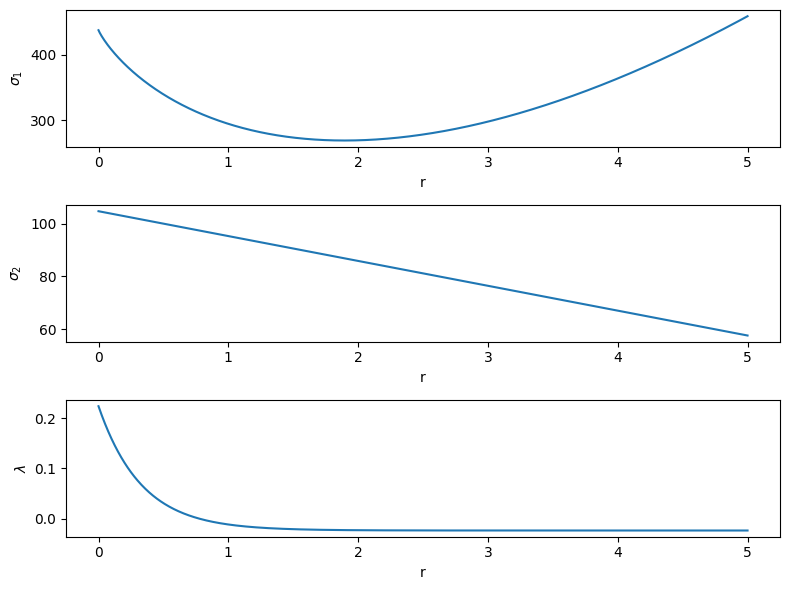

In [52]:
r = np.linspace(0,5,1000)
sigma = sigma_r(r, *params[:4])  
sigma1 = sigma1_r(r, *params[4:6]) 
lam = lambda_r(r, *params[6:9])   


fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (8,6))
ax1.plot(r, sigma, label = 'sigma')
ax2.plot(r, sigma1, label = 'sigma1')
ax3.plot(r, lam, label = 'lambda')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('r')
ax1.set_ylabel(r'$\sigma_1$')
ax2.set_ylabel(r'$\sigma_2$')
ax3.set_ylabel(r'$\lambda$')
# plt.yscale('symlog')
# plt.legend()
plt.tight_layout()
plt.show()

Total observed count: 595182
Normalization constant: 0.9999999978810493


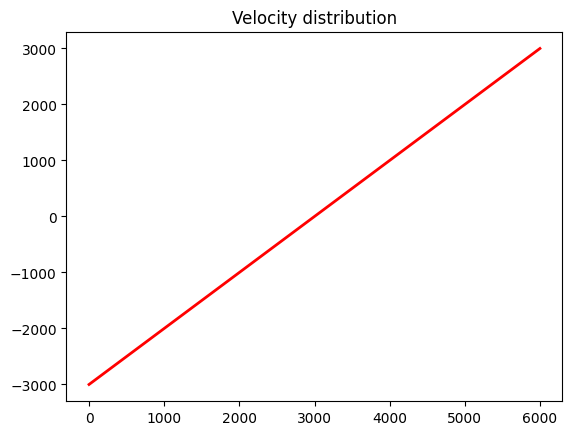

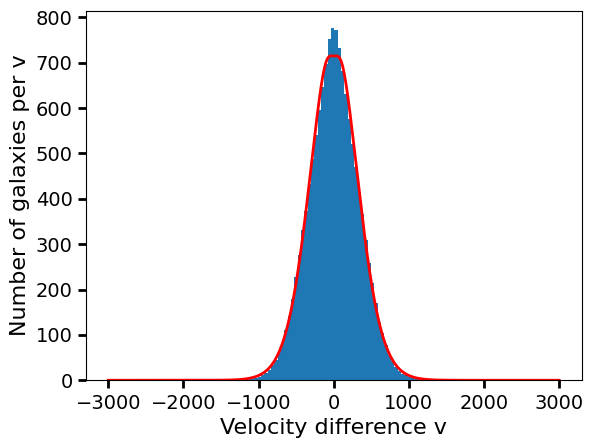

In [28]:
r_max=5 # Mpc - provide upper limit of radial separation

#Marginalize dist with uniform P(r) = 1/r_max
def marginalized_P_x(x, params, r_max):
    integral_r, _ = quad(lambda r: f_x(x, sigma_r(r, *params[:4]),sigma1_r(r, *params[4:6]), lambda_r(r, *params[6:9])),
                         0, r_max)
    return integral_r / r_max  


x_range = np.linspace(-3000, 3000, 6000)
marginalized_dist = np.array([marginalized_P_x(x, params, r_max) for x in x_range])

total_count = sum(N_obs for _, _, x_bins in binned_data for (_, _, N_obs) in x_bins)
print("Total observed count:", total_count)


def normalization_const_r(params, r_max):
    #f(y,x) form, with y being the inner integral variable!!
    def integrand(r, x, params):
        sigma = sigma_r(r, *params[:4])    
        sigma1 = sigma1_r(r, *params[4:6]) 
        lam = lambda_r(r, *params[6:9]) 
        return f_x(x, sigma, sigma1, lam)  

    # Integrate over r first then x
    total_area, _ = dblquad(integrand, -np.inf, np.inf, lambda x: 0, lambda x: r_max, args=(params,))
    return total_area / (r_max)
    
A = normalization_const_r(params, r_max)
print("Normalization constant:", A)

scaled_p = marginalized_dist * total_count / (A )
plt.plot(x_range, color="red", linewidth=2)
plt.title("Velocity distribution")
plt.show()


bin_heights, bin_edges = np.histogram(np.concatenate((x_values,y_values,z_values),axis=None),bins=80, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width= bin_edges[1] - bin_edges[0] 
number_density = bin_heights / bin_width
plt.bar(bin_centers, number_density, width=bin_width, align='center')
plt.plot(x_range, scaled_p, color="red", linewidth=2,label=f"N={total_count:.0f}")
plt.xlabel("Velocity difference v", fontsize=16)
plt.ylabel("Number of galaxies per v", fontsize=16)
plt.tick_params(axis='both', which='major', length=6, width=2, labelsize=14)
# plt.savefig("Marginalized_distribution_allr_M13_5_14.pdf", dpi=500)
plt.show()



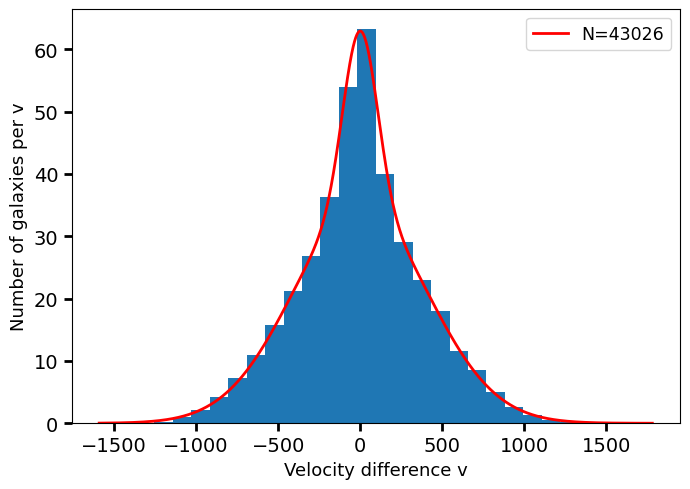

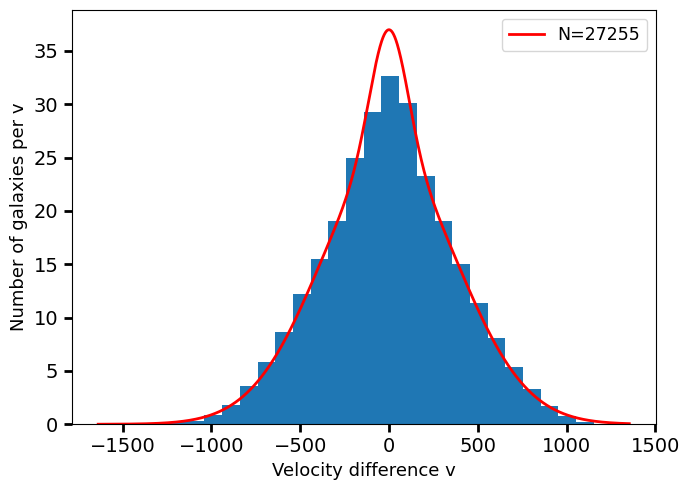

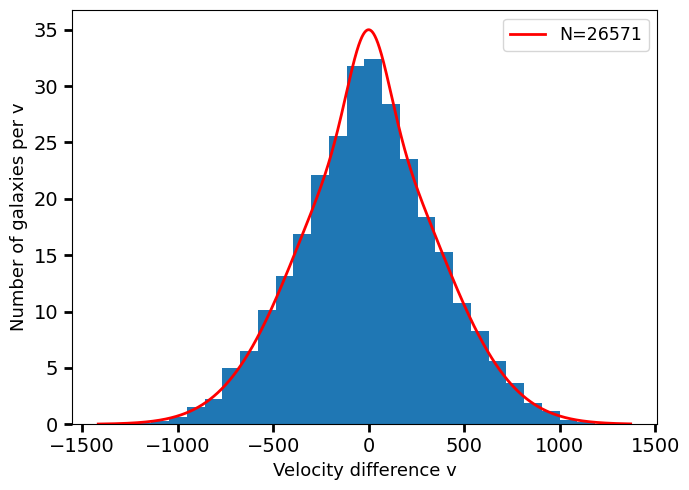

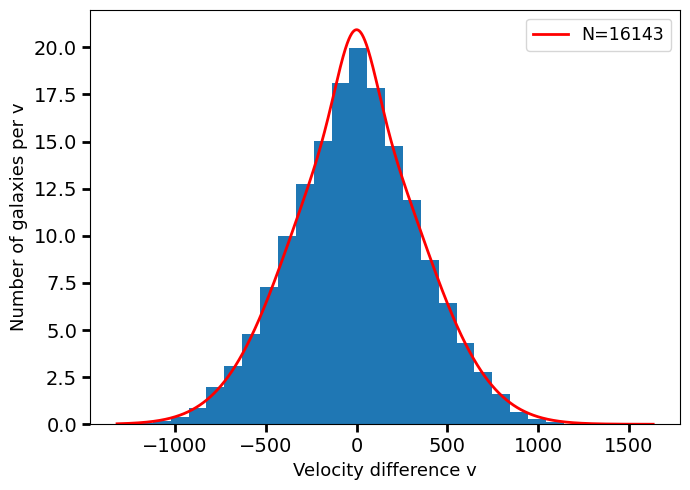

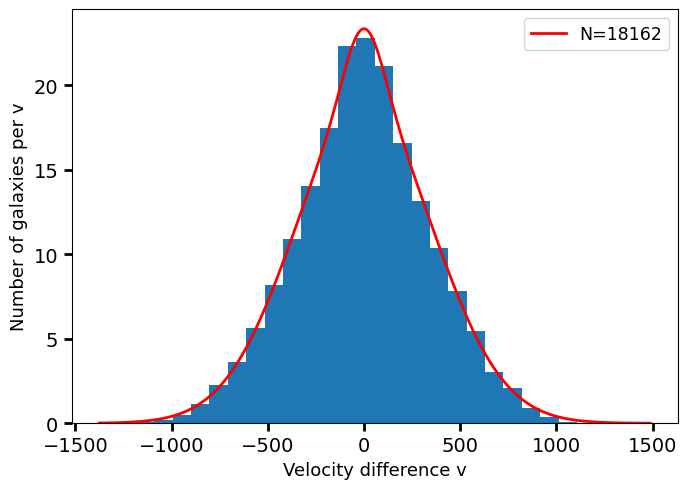

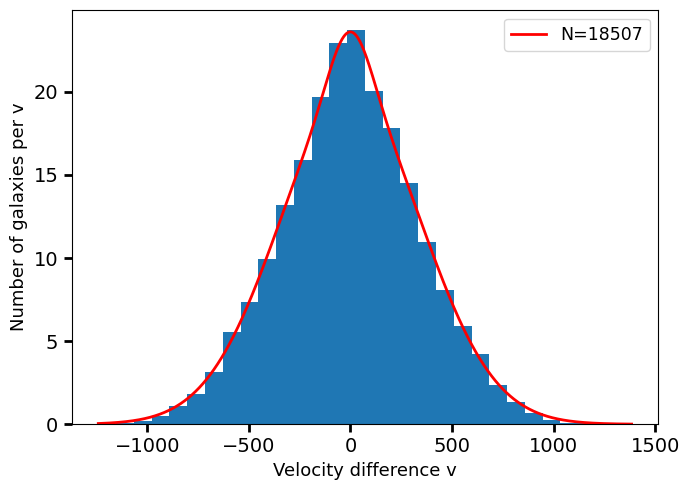

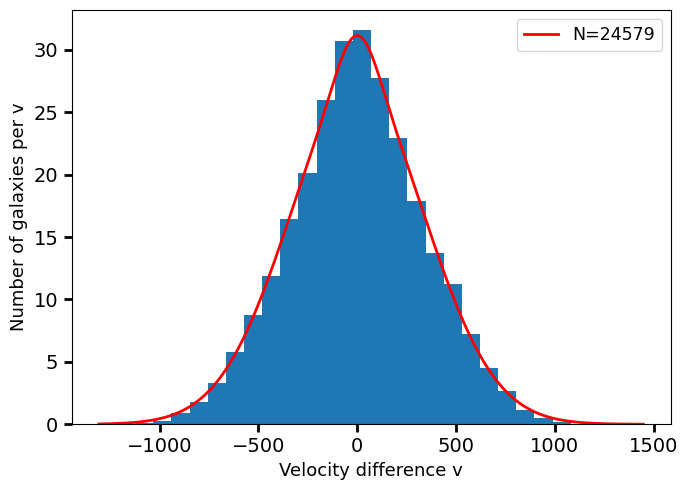

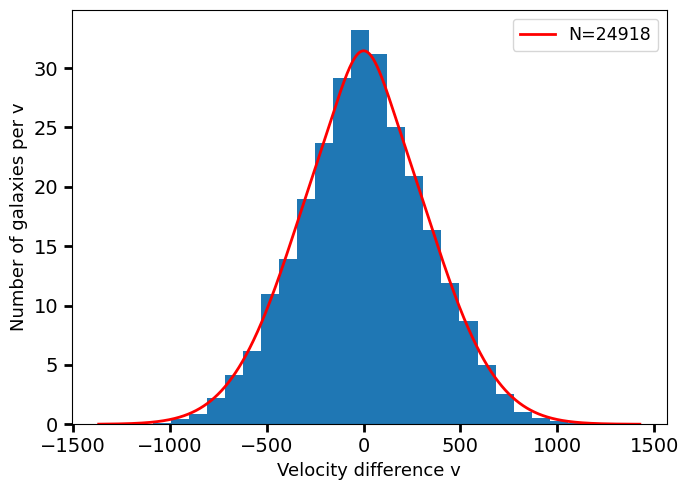

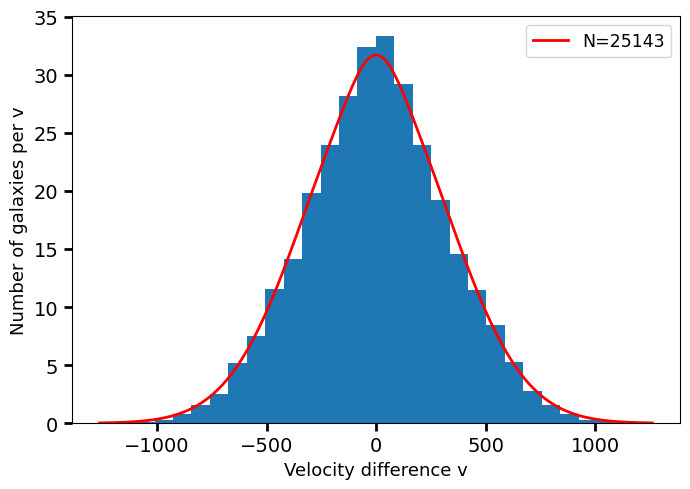

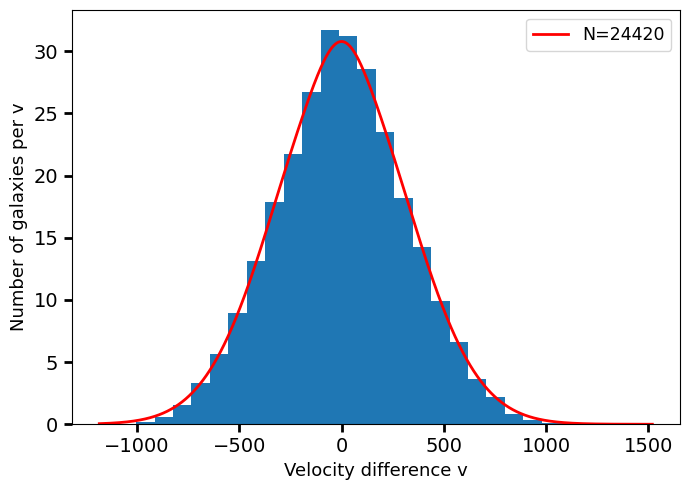

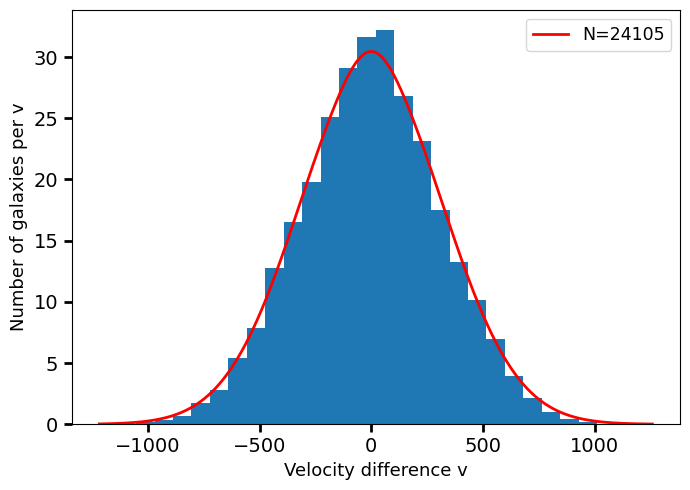

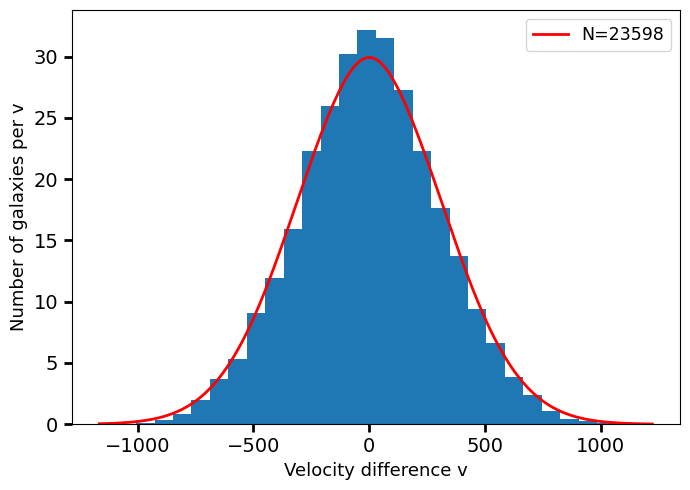

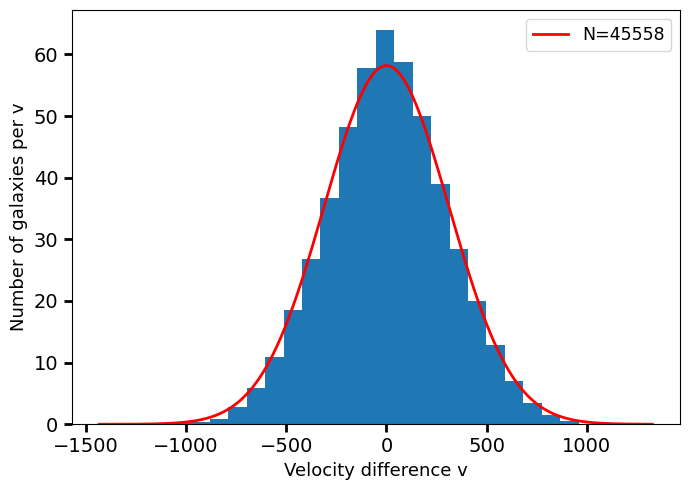

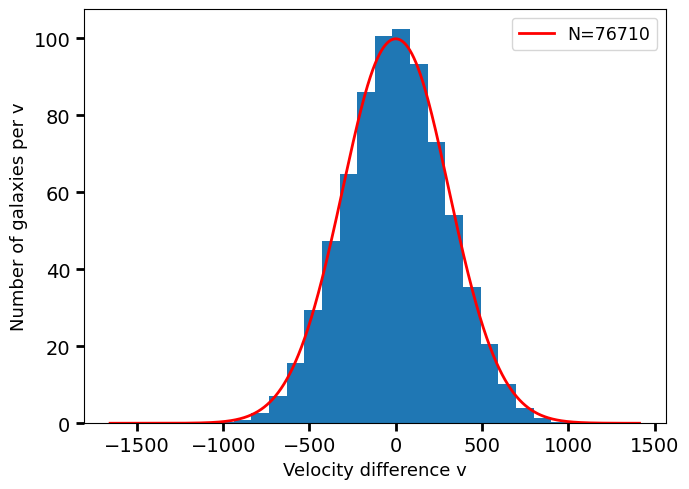

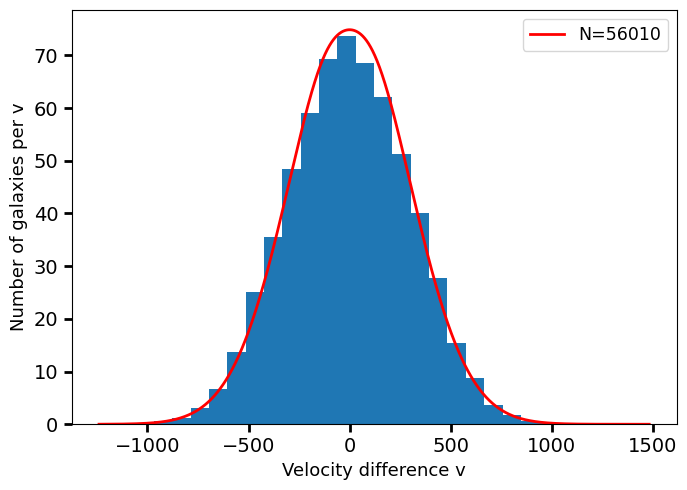

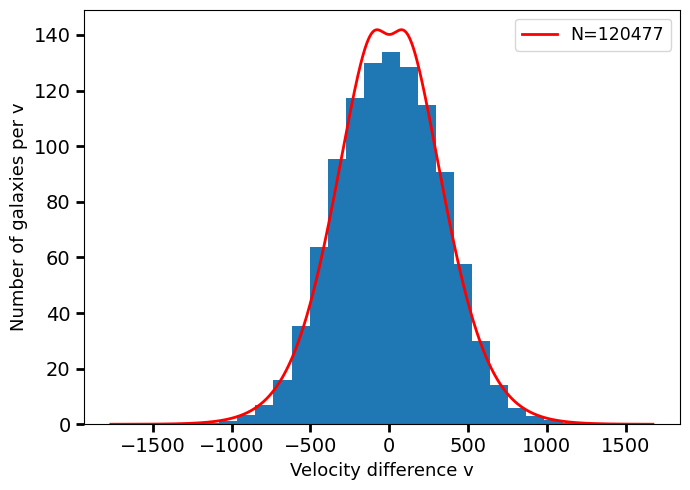

In [29]:
def marginalized_P_x_specific_r(x, params, r_min , r_max):
    integral_r, _ = quad(lambda r: f_x(x, sigma_r(r, *params[:4]),sigma1_r(r, *params[4:6]), lambda_r(r, *params[6:9])),
                         r_min, r_max)
    return integral_r / ((r_max - r_min))




def normalization_const_specific_r(params, r_min, r_max):
    #f(y,x) form with y being the inner integral variable!!
    def integrand(r, x, params):
        sigma = sigma_r(r, *params[:4])    
        sigma1 = sigma1_r(r, *params[4:6]) 
        lam = lambda_r(r, *params[6:9]) 
        return f_x(x, sigma, sigma1, lam) 

    # Integrate over r first then x
    total_area, _ = dblquad(integrand, -np.inf, np.inf, lambda x: r_min, lambda x: r_max, args=(params,))
    return total_area / (r_max - r_min)


def marginalized_P_plots(velocity_values,r_bins,opt_params):
    """
    velocity_values = velocity values inside each r bin (unbinned)
    r_bins = list with bin edges of each r bin
    opt_params = fitted parameters of scale dependent functions
    """
    # fig=figure(figsize=(10,10))
    for i in range(len(r_bins)):
        #Calculate normalization constant
        fig=figure(figsize=(7,5))
        frame=fig.add_subplot(1,1,1)
        A = normalization_const_specific_r(opt_params, r_bins[i][0],r_bins[i][1])
        # print(f"Normalization constant for bin {r_bins[i][0]} Mpc - {r_bins[i][1]} Mpc = {A} ")
        
        #Generate bin-marginalized distribution inside each r bin
        x_range = np.linspace(np.min(velocity_values[i]), np.max(velocity_values[i]), 7000)

        marginalized_dist_specific_r = np.array([marginalized_P_x_specific_r(x, opt_params, r_bins[i][0],r_bins[i][1]) for x in x_range])

        
        # frame=fig.add_subplot(len(r_bins),1,i+1 )
        bin_heights, bin_edges = np.histogram(velocity_values[i], bins=30, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width= bin_edges[1] - bin_edges[0] 
        number_density = bin_heights / bin_width
        hist_area=len(velocity_values[i])
        scaled_p = marginalized_dist_specific_r * hist_area / A
        frame.bar(bin_centers, number_density, width=bin_width, align='center')
        frame.plot(x_range, scaled_p, color="red", linewidth=2, label=f"N={hist_area:.0f}")
        frame.set_xlabel('Velocity difference v', fontsize=13)
        frame.set_ylabel('Number of galaxies per v', fontsize=13)
        frame.tick_params(axis='both', which='major', length=6, width=2, labelsize=14)
        frame.legend(fontsize=12.5, loc="upper right")
        fig.tight_layout()
        #TO SAVE IMAGE
        # fig.savefig(f"Marginalized_distribution_allr_M13_5_14__bin_{r_bins[i][0]:.1f}_{r_bins[i][1]:.1f}.pdf", dpi=500)
        show()

        
marginalized_P_plots(unbinned_velocity_values_in_each_rbin,r_bins,params)#,10**14,10**14.5)   

Comments from Sowmya:

I could have used MCMC fitting procedures instead of the one I used here, so I would suggest adding that instead of what I did. Additionally, I should have explored more combinations of scale-dependent functions for the parameters. Good luck, and I would really appreciate it if you could keep me updated on the progress made in finding/improving the model at the end of your project!